In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib.util
import sys
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from datetime import datetime
from IPython.display import display  # Jupyter-safe
from io import StringIO
import csv
import json

In [2]:
torch_spec = importlib.util.find_spec("torch")
print(torch_spec)

ModuleSpec(name='torch', loader=<_frozen_importlib_external.SourceFileLoader object at 0x701da4b8f040>, origin='/home/fadluw/anaconda3/envs/misk/lib/python3.10/site-packages/torch/__init__.py', submodule_search_locations=['/home/fadluw/anaconda3/envs/misk/lib/python3.10/site-packages/torch'])


Params

In [3]:
# Parameters
aligned_data_root = Path("aligned_dataset")
window_size = 70


Load and Accumulate Data Across Trials

In [4]:
# Storage for all trials
X_trials = []
y_trials = []

# Load aligned IMU and angle data from all trials
for trial_dir in sorted(aligned_data_root.glob("trial_*")):
    X_path = trial_dir / "X.csv"
    y_path = trial_dir / "Y.csv"
    if not X_path.exists() or not y_path.exists():
        print(f"Missing data in {trial_dir}, skipping.")
        continue

    X_df = pd.read_csv(X_path)
    y_df = pd.read_csv(y_path)

    # Drop unnecessary columns
    X_df = X_df.drop(columns=['Millis'], errors='ignore')
    y_df = y_df.drop(columns=['time'], errors='ignore')

    assert len(X_df) == len(y_df), f"Length mismatch in {trial_dir}"

    X_trials.append(X_df.values)
    y_trials.append(y_df.values)


 Concatenate and Normalize

In [5]:
# Concatenate all trials
X_all = np.concatenate(X_trials, axis=0)
y_all = np.concatenate(y_trials, axis=0)

# Scale features and targets
scaler_X = StandardScaler().fit(X_all)
scaler_y = StandardScaler().fit(y_all)

X_all_scaled = scaler_X.transform(X_all)
y_all_scaled = scaler_y.transform(y_all)


Apply Sliding Window

In [6]:
def create_windows(X, y, window_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size-1])  # predict last frame
    return np.array(X_windowed), np.array(y_windowed)

X_all, y_all = create_windows(X_all_scaled, y_all_scaled, window_size)


Train/Validation/Test Split

In [7]:
# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.4, random_state=42
)

# Second split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


Wrap in PyTorch Datasets and Check Shapes

In [8]:
# Wrap in PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

# Sanity check
x0, y0 = train_dataset[0]
print("Sample input shape:", x0.shape)
print("Sample target shape:", y0.shape)


Sample input shape: torch.Size([70, 30])
Sample target shape: torch.Size([24])


In [9]:
X_df

,AccelX_chest,AccelY_chest,AccelZ_chest,GyroX_chest,GyroY_chest,GyroZ_chest,AccelX_right_leg,AccelY_right_leg,AccelZ_right_leg,GyroX_right_leg,...,AccelZ_right_arm,GyroX_right_arm,GyroY_right_arm,GyroZ_right_arm,AccelX_left_arm,AccelY_left_arm,AccelZ_left_arm,GyroX_left_arm,GyroY_left_arm,GyroZ_left_arm
0,-0.974,-0.158,0.247,-4.340,-0.910,-11.060,-0.989,-0.250,0.010,0.000,...,-0.051,-13.580,-6.230,-1.330,-0.797,-0.447,-0.423,-7.350,2.170,-0.140
1,-0.980,-0.165,0.252,-3.792,-1.534,-11.004,-0.984,-0.252,0.011,-0.122,...,-0.042,-12.654,-8.077,0.058,-0.792,-0.451,-0.419,-6.227,2.173,-0.279
2,-0.983,-0.164,0.261,-3.929,-3.166,-10.819,-0.987,-0.245,0.009,-0.190,...,-0.096,-8.432,-8.326,1.572,-0.796,-0.450,-0.426,-4.230,2.706,-0.079
3,-0.979,-0.163,0.258,-4.627,-5.351,-10.670,-0.989,-0.243,0.006,-0.582,...,-0.087,-9.703,-7.385,3.721,-0.807,-0.433,-0.432,-3.994,2.045,-0.338
4,-0.971,-0.178,0.250,-4.464,-6.365,-10.485,-0.988,-0.245,0.005,-0.766,...,-0.047,-10.517,-10.129,3.406,-0.807,-0.419,-0.436,-6.260,0.949,-1.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,-0.940,-0.069,0.031,-6.115,-1.804,4.283,-0.969,-0.289,-0.103,-9.457,...,-0.168,-14.638,4.156,-17.374,-0.763,0.152,-0.485,8.219,28.189,29.638
8668,-0.944,-0.091,0.038,2.332,-5.765,2.600,-0.926,-0.299,-0.056,-3.912,...,-0.173,-16.731,0.340,-8.773,-0.792,0.125,-0.455,12.960,20.106,34.967
8669,-0.967,-0.112,0.054,9.001,-8.268,2.011,-0.921,-0.247,-0.058,-6.688,...,-0.175,-15.440,-1.678,-0.449,-0.754,0.192,-0.370,23.668,15.518,38.936
8670,-0.995,-0.118,0.066,13.113,-8.690,1.190,-0.944,-0.206,-0.138,-11.573,...,-0.191,-10.556,-1.145,9.450,-0.721,0.279,-0.408,20.761,21.690,34.221


In [10]:
y_df

,right ankle,left ankle,right knee,left knee,right hip,left hip,right shoulder,left shoulder,right elbow,left elbow,...,right thigh,left thigh,pelvis,trunk,shoulders,head,right arm,left arm,right forearm,left forearm
0,-38.866456,-68.533373,7.446345,5.135329,2.958860,3.836582,9.499746,8.100783,-6.346643,-7.807354,...,-82.818647,-81.940925,2.390685,93.411106,0.944986,85.548986,-76.277761,-77.676724,-82.624404,-85.484078
1,-38.343883,-67.663694,7.098845,5.211061,2.763779,3.813969,9.576901,7.943975,-6.655394,-8.003499,...,-82.907602,-81.857412,2.413493,93.304981,0.619276,85.720766,-76.094480,-77.727406,-82.749874,-85.730905
2,-38.564056,-68.091949,7.233265,5.214349,2.744306,3.736667,9.660954,7.744906,-6.794059,-8.090523,...,-82.852892,-81.860531,2.423980,93.230797,0.349706,85.798934,-75.936244,-77.852291,-82.730303,-85.942814
3,-38.867967,-68.663526,7.427086,5.242732,2.715914,3.650176,9.714999,7.533809,-6.846494,-8.130385,...,-82.788269,-81.854007,2.426682,93.137782,0.094621,85.755406,-75.789184,-77.970374,-82.635678,-86.100759
4,-39.087929,-69.071104,7.536546,5.309117,2.611634,3.531403,9.696660,7.321739,-6.858430,-8.130518,...,-82.750948,-81.831179,2.425955,92.996181,-0.150368,85.646848,-75.665922,-78.040843,-82.524352,-86.171361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,-22.447342,-607.760028,188.743687,-358.873602,-1.881603,10.083178,188.850720,-699.471566,721.165087,-556.179930,...,-89.796738,-77.831958,5.459484,95.548735,8.988479,77.853373,-79.064415,-787.386702,102.100672,-263.566631
8668,-21.076632,-609.004113,189.223845,-358.897816,-2.075384,10.120379,188.626724,-699.752464,721.522086,-556.221750,...,-89.859490,-77.663727,5.402113,95.417706,8.997585,77.754060,-79.157382,-787.536570,102.364704,-263.758320
8669,-19.904360,-609.743294,189.539555,-358.854063,-2.330769,10.171159,188.502615,-700.206764,721.620868,-556.028654,...,-89.967538,-77.465611,5.350489,95.270369,8.890905,77.469419,-79.134155,-787.843534,102.486713,-263.872188
8670,-19.493500,-609.548309,189.649674,-358.817074,-2.539074,10.227793,188.531232,-700.774812,721.432229,-555.489361,...,-90.069378,-77.302511,5.310810,95.163903,8.632980,77.080014,-78.999072,-788.305116,102.433158,-263.794477


# Model

Model Definition

In [11]:
class IMULSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, fc_hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # self.fc_head = nn.Sequential(
        #     nn.Linear(hidden_size, fc_hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(fc_hidden_size, output_size)
        # )

        # self.fc1 = nn.Linear(hidden_size, 256)
        # self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(256, 128)
        # self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(128, 64)
        # self.relu3 = nn.ReLU()
        # self.fc4 = nn.Linear(64, output_size)

        # self.dropout1 = nn.Dropout(p=0.1)  # You can try 0.3 to start
        # self.dropout2 = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # out, _ = self.lstm(x, (h0, c0))
        # last_step_output = out[:, -1, :]  # Take output from last timestep

        # return self.fc_head(last_step_output)
        out, _ = self.lstm(x)
        x = out[:, -1, :]
        x = self.relu1(self.fc1(x))
        # x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        # x = self.dropout2(x)
        # x = self.relu3(self.fc3(x))
        
        return self.fc3(x)



Logging Setup

In [13]:
# Setup log directory
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = os.path.join('logs', f'run_{timestamp}')
os.makedirs(log_dir, exist_ok=True)

LOG_PATH = os.path.join(log_dir, 'training_log.txt')
csv_path = os.path.join(log_dir, 'metrics.csv')
SAVE_STDOUT = True  # If True, also print to terminal


CSV Logging Setup

In [14]:
# Metrics CSV setup
csv_fields = ['epoch', 'train_mse', 'train_mae', 'train_rmse', 'train_r2',
              'val_mse', 'val_mae', 'val_rmse', 'val_r2']

csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_fields)
csv_writer.writeheader()


79

In [15]:
print("Target sample shape:", train_dataset[0][1].shape)


Target sample shape: torch.Size([24])


Logger Class

In [16]:
class DualLogger:
    def __init__(self, filepath, print_to_stdout=True):
        self.log_file = open(filepath, 'w')
        self.print_to_stdout = print_to_stdout

    def log(self, text):
        self.log_file.write(text + '\n')
        self.log_file.flush()
        if self.print_to_stdout:
            print(text)

    def close(self):
        self.log_file.close()

logger = DualLogger(LOG_PATH, print_to_stdout=SAVE_STDOUT)


Hyperparameters and Summary

In [17]:
# Hyperparameters
hidden_size = 256
num_layers = 2
batch_size = 50
epochs = 20
learning_rate = 1e-3

# Show config info
print("=" * 70)
print(f"Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"Hyperparameters:")
print(f"  Hidden Size   = {hidden_size}")
print(f"  Num Layers    = {num_layers}")
print(f"  Batch Size    = {batch_size}")
print(f"  Epochs        = {epochs}")
print(f"  Learning Rate = {learning_rate}")
print(f"  Window Size   = {window_size}")
print("=" * 70)

# Save config to file
hyperparams = {
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
}
with open(os.path.join(log_dir, 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparams, f, indent=2)


Training started: 2025-04-20 14:20:35
Device: CUDA
Hyperparameters:
  Hidden Size   = 256
  Num Layers    = 2
  Batch Size    = 50
  Epochs        = 20
  Learning Rate = 0.001
  Window Size   = 70


Model, Optimizer, Dataloaders

In [31]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model setup
input_size = train_dataset[0][0].shape[1]
output_size = train_dataset[0][1].shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IMULSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()
# ── Log model architecture ───────────────────────────────
arch_path = os.path.join(log_dir, 'model_architecture.txt')
with open(arch_path, 'w') as f:
    f.write(str(model))
print(f"✅ Saved model architecture to: {arch_path}")


✅ Saved model architecture to: logs/run_2025-04-20_14-20-35/model_architecture.txt


Training Loop

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

logger.log(f"\nStarting training for {epochs} epochs...\n")

for epoch in range(epochs):
    # --- TRAINING PASS ---
    model.train()
    train_preds, train_trues = [], []

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        Xb, yb = X_batch.to(device), y_batch.to(device)
        pred = model(Xb)

        # loss in scaled space (for backprop)
        loss = mse_loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stash for degree‑space metrics
        train_preds.append(pred.detach().cpu())
        train_trues.append(yb.detach().cpu())

        # optional per‑100‐batch log of scaled loss
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            avg_scaled = loss.item()
            logger.log(f"  Batch {batch_idx+1:>4}/{len(train_loader)} – Scaled MSE Loss: {avg_scaled:.4f}")

    # concatenate and inverse‑transform to degrees
    y_train_scaled = torch.cat(train_trues).numpy()
    y_pred_scaled  = torch.cat(train_preds).numpy()
    y_train_deg    = scaler_y.inverse_transform(y_train_scaled)
    y_pred_deg     = scaler_y.inverse_transform(y_pred_scaled)

    # compute train metrics in degrees
    mse_tr = mean_squared_error(y_train_deg.ravel(), y_pred_deg.ravel())
    rmse_tr = np.sqrt(mse_tr)
    mae_tr  = mean_absolute_error(y_train_deg.ravel(), y_pred_deg.ravel())
    r2_tr   = r2_score(y_train_deg.ravel(), y_pred_deg.ravel())

    # --- VALIDATION PASS ---
    model.eval()
    val_preds, val_trues = [], []

    with torch.no_grad():
        for X_val, y_val in val_loader:
            pred = model(X_val.to(device))
            val_preds.append(pred.cpu())
            val_trues.append(y_val.cpu())

    # concatenate and inverse‑transform to degrees
    y_val_scaled = torch.cat(val_trues).numpy()
    y_pred_val_scaled = torch.cat(val_preds).numpy()
    y_val_deg   = scaler_y.inverse_transform(y_val_scaled)
    y_pred_val_deg = scaler_y.inverse_transform(y_pred_val_scaled)

    # compute val metrics in degrees
    mse_v  = mean_squared_error(y_val_deg.ravel(), y_pred_val_deg.ravel())
    rmse_v = np.sqrt(mse_v)
    mae_v  = mean_absolute_error(y_val_deg.ravel(), y_pred_val_deg.ravel())
    r2_v   = r2_score(y_val_deg.ravel(), y_pred_val_deg.ravel())

    # --- LOG & SAVE METRICS ---
    logger.log(f"Epoch {epoch+1}/{epochs}")
    logger.log(f"  ↳ Train (deg) → MSE: {mse_tr:.2f}, MAE: {mae_tr:.2f}, RMSE: {rmse_tr:.2f}°, R²: {r2_tr:.4f}")
    logger.log(f"  ↳ Val   (deg) → MSE: {mse_v:.2f}, MAE: {mae_v:.2f}, RMSE: {rmse_v:.2f}°, R²: {r2_v:.4f}")
    logger.log("-" * 70)

    csv_writer.writerow({
        'epoch':    epoch + 1,
        'train_mse':  mse_tr,
        'train_mae':  mae_tr,
        'train_rmse': rmse_tr,
        'train_r2':       r2_tr,
        'val_mse':    mse_v,
        'val_mae':    mae_v,
        'val_rmse':   rmse_v,
        'val_r2':         r2_v,
    })
    csv_file.flush()

csv_file.close()
logger.close()




Starting training for 20 epochs...

  Batch  100/1098 – Scaled MSE Loss: 0.2248
  Batch  200/1098 – Scaled MSE Loss: 0.1555
  Batch  300/1098 – Scaled MSE Loss: 0.1475
  Batch  400/1098 – Scaled MSE Loss: 0.1539
  Batch  500/1098 – Scaled MSE Loss: 0.1410
  Batch  600/1098 – Scaled MSE Loss: 0.2566
  Batch  700/1098 – Scaled MSE Loss: 0.1740
  Batch  800/1098 – Scaled MSE Loss: 0.0990
  Batch  900/1098 – Scaled MSE Loss: 0.1317
  Batch 1000/1098 – Scaled MSE Loss: 0.1025
  Batch 1098/1098 – Scaled MSE Loss: 0.1221
Epoch 1/20
  ↳ Train (deg) → MSE: 18629.60, MAE: 66.77, RMSE: 136.49°, R²: 0.8538
  ↳ Val   (deg) → MSE: 11936.20, MAE: 51.33, RMSE: 109.25°, R²: 0.9073
----------------------------------------------------------------------
  Batch  100/1098 – Scaled MSE Loss: 0.0745
  Batch  200/1098 – Scaled MSE Loss: 0.0645
  Batch  300/1098 – Scaled MSE Loss: 0.1172
  Batch  400/1098 – Scaled MSE Loss: 0.0816
  Batch  500/1098 – Scaled MSE Loss: 0.1133
  Batch  600/1098 – Scaled MSE Loss

Target Distribution Inspection

In [21]:
# Inspect target (y) distribution in training and validation sets
train_y = train_dataset[:][1]
val_y = val_dataset[:][1]

print("Train y mean/std:", train_y.mean().item(), train_y.std().item())
print("Val   y mean/std:", val_y.mean().item(), val_y.std().item())
print("Train y min/max:", train_y.min().item(), train_y.max().item())
print("Val   y min/max:", val_y.min().item(), val_y.max().item())


Train y mean/std: -0.000114437221782282 0.9994580745697021
Val   y mean/std: -0.0010422483319416642 1.007059931755066
Train y min/max: -9.726888656616211 8.683670043945312
Val   y min/max: -9.673686981201172 8.659698486328125


Save Model Weights

In [ ]:
# Save the trained model weights
weights_path = os.path.join(log_dir, "model_weights.pth")
torch.save(model.state_dict(), weights_path)

Setup for Test Evaluation

In [23]:
# Define loss function (if not already defined)
criterion = nn.MSELoss()

# Wrap test data into a Dataset and DataLoader
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

Run Test Evaluation

In [ ]:
# --- Evaluate model on test set ---
model.eval()
all_preds   = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)
        all_preds.append(  preds.cpu() )
        all_targets.append(y_batch.cpu())

# Concatenate into big arrays
y_true = torch.cat(all_targets).numpy()
y_pred = torch.cat(all_preds).numpy()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import os
import torch

# 1) Metrics in the scaled space
mse_scaled  = mean_squared_error(y_true, y_pred)
rmse_scaled = np.sqrt(mse_scaled)
mae_scaled  = mean_absolute_error(y_true, y_pred)
r2_scaled   = r2_score(y_true, y_pred)

print(f"Scaled-space Test MSE: {mse_scaled:.4f}")
print(f"Scaled-space Test RMSE: {rmse_scaled:.4f}")
print(f"Scaled-space Test MAE:  {mae_scaled:.4f}")
print(f"Scaled-space Test R²:   {r2_scaled:.4f}")

# 2) Inverse-transform back to degrees
y_true_deg = scaler_y.inverse_transform(y_true)
y_pred_deg = scaler_y.inverse_transform(y_pred)

# 3) Overall metrics in degrees
mse_deg   = mean_squared_error(y_true_deg.ravel(), y_pred_deg.ravel())
rmse_deg  = np.sqrt(mse_deg)
mae_deg   = mean_absolute_error(y_true_deg.ravel(), y_pred_deg.ravel())
r2_deg    = r2_score(y_true_deg.ravel(), y_pred_deg.ravel())

print(f"Degree-space Test MSE: {mse_deg:.2f}°")
print(f"Degree-space Test RMSE: {rmse_deg:.2f}°")
print(f"Degree-space Test MAE:  {mae_deg:.2f}°")
print(f"Degree-space Test R²:   {r2_deg:.4f}")

# ── 4) Save test metrics ──────────────────────────────────
metrics = {
    "scaled_mse":   mse_scaled,
    "scaled_rmse":  rmse_scaled,
    "scaled_mae":   mae_scaled,
    "scaled_r2":    r2_scaled,
    "deg_mse":      mse_deg,
    "deg_rmse":     rmse_deg,
    "deg_mae":      mae_deg,
    "deg_r2":       r2_deg
}
df = pd.DataFrame([metrics])
csv_path = os.path.join(log_dir, "test_metrics.csv")
df.to_csv(csv_path, index=False)
print(f"✅ Saved test metrics to: {csv_path}")





Scaled-space Test MSE: 0.0073
Scaled-space Test RMSE: 0.0853
Scaled-space Test MAE:  0.0552
Scaled-space Test R²:   0.9927
Degree-space Test MSE: 650.80°
Degree-space Test RMSE: 25.51°
Degree-space Test MAE:  13.90°
Degree-space Test R²:   0.9949
✅ Saved test metrics to: logs/run_2025-04-20_14-20-35/test_metrics.csv
✅ Saved model architecture to: logs/run_2025-04-20_14-20-35/model_architecture.txt
✅ Saved model weights to: logs/run_2025-04-20_14-20-35/model_weights.pth


Convert Test Outputs to NumPy (Optional for Analysis/Plotting)

In [25]:
# Convert predictions and targets to NumPy for visualization or metrics
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

In [26]:
print(all_preds.shape, all_targets.shape)
print(scaler_y)


(18293, 24) (18293, 24)
StandardScaler()


✅ Best joints (lowest RMSE):
          Joint       MSE      RMSE       MAE        R2
16       pelvis  0.866923  0.931087  0.719580  0.980993
15   left thigh  3.096624  1.759723  1.207569  0.980919
17        trunk  3.123663  1.767389  1.261515  0.992077
14  right thigh  3.460343  1.860200  1.225018  0.979318
18    shoulders  3.920411  1.980003  1.425986  0.990766

⚠️ Worst joints (highest RMSE):
            Joint          MSE       RMSE        MAE        R2
0     right ankle  1371.769409  37.037406  22.734966  0.994241
8     right elbow  1458.667847  38.192510  26.996813  0.994267
7   left shoulder  1651.174316  40.634644  27.681961  0.994948
9      left elbow  1846.450317  42.970342  30.184521  0.993870
23   left forearm  2638.313232  51.364513  36.168449  0.993533


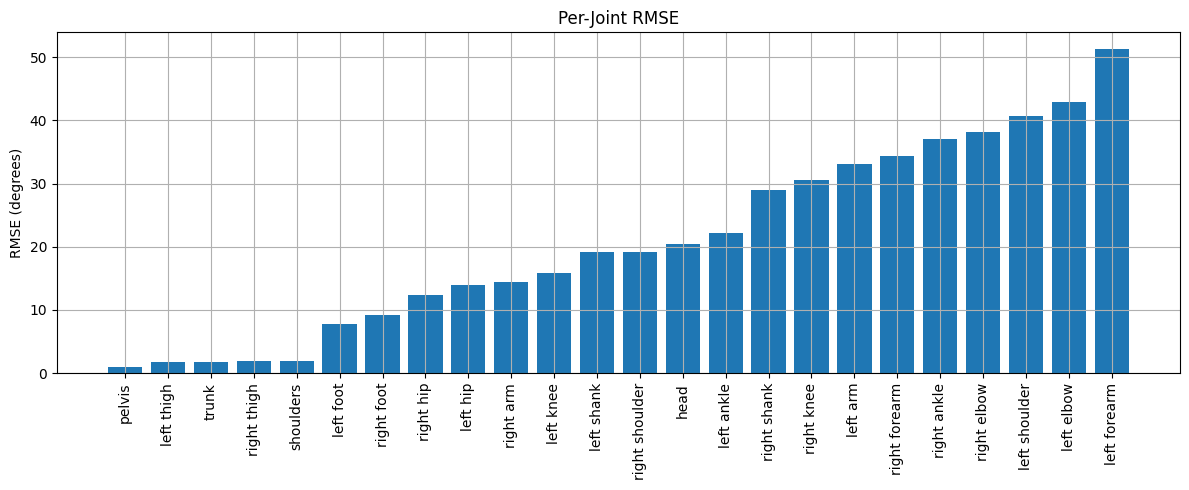

✅ Plot saved to: logs/run_2025-04-20_14-20-35/per_joint_rmse.png


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

# --- Step 0: Ensure tensors in all_preds and all_targets ---
all_preds = [torch.as_tensor(p) if isinstance(p, np.ndarray) else p for p in all_preds]
all_preds = [p.view(1, -1) if p.ndim == 1 else p for p in all_preds]

all_targets = [torch.as_tensor(t) if isinstance(t, np.ndarray) else t for t in all_targets]
all_targets = [t.view(1, -1) if t.ndim == 1 else t for t in all_targets]

# --- Step 1: Concatenate tensors ---
y_pred_tensor = torch.cat(all_preds, dim=0)
y_true_tensor = torch.cat(all_targets, dim=0)

# --- Step 2: Inverse transform to original scale ---
y_pred_np = y_pred_tensor.numpy()
y_true_np = y_true_tensor.numpy()

y_pred_orig = scaler_y.inverse_transform(y_pred_np)
y_true_orig = scaler_y.inverse_transform(y_true_np)

# --- Step 3: Compute per-joint errors ---
n_joints = y_true_orig.shape[1]
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for i in range(n_joints):
    mse = mean_squared_error(y_true_orig[:, i], y_pred_orig[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_orig[:, i], y_pred_orig[:, i])
    r2 = r2_score(y_true_orig[:, i], y_pred_orig[:, i])

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# --- Step 4: Organize into DataFrame ---
joint_names = [
    "right ankle", "left ankle", "right knee", "left knee", "right hip", "left hip",
    "right shoulder", "left shoulder", "right elbow", "left elbow",
    "right foot", "left foot", "right shank", "left shank",
    "right thigh", "left thigh", "pelvis", "trunk", "shoulders", "head",
    "right arm", "left arm", "right forearm", "left forearm"
]

joint_errors = pd.DataFrame({
    "Joint": joint_names,
    "MSE": mse_list,
    "RMSE": rmse_list,
    "MAE": mae_list,
    "R2": r2_list
}).sort_values(by="RMSE")

# --- Step 5: Display best/worst joints ---
print("✅ Best joints (lowest RMSE):")
print(joint_errors.head(5))
print("\n⚠️ Worst joints (highest RMSE):")
print(joint_errors.tail(5))

# --- Step 6: Plot RMSE ---
plt.figure(figsize=(12, 5))
plt.bar(joint_errors["Joint"], joint_errors["RMSE"])
plt.xticks(rotation=90)
plt.ylabel("RMSE (degrees)")
plt.title("Per-Joint RMSE")
plt.grid(True)
plt.tight_layout()

os.makedirs(log_dir, exist_ok=True)
plot_path = os.path.join(log_dir, "per_joint_rmse.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Plot saved to: {plot_path}")


PLOTS

✅ Saved: training_validation_metrics.png


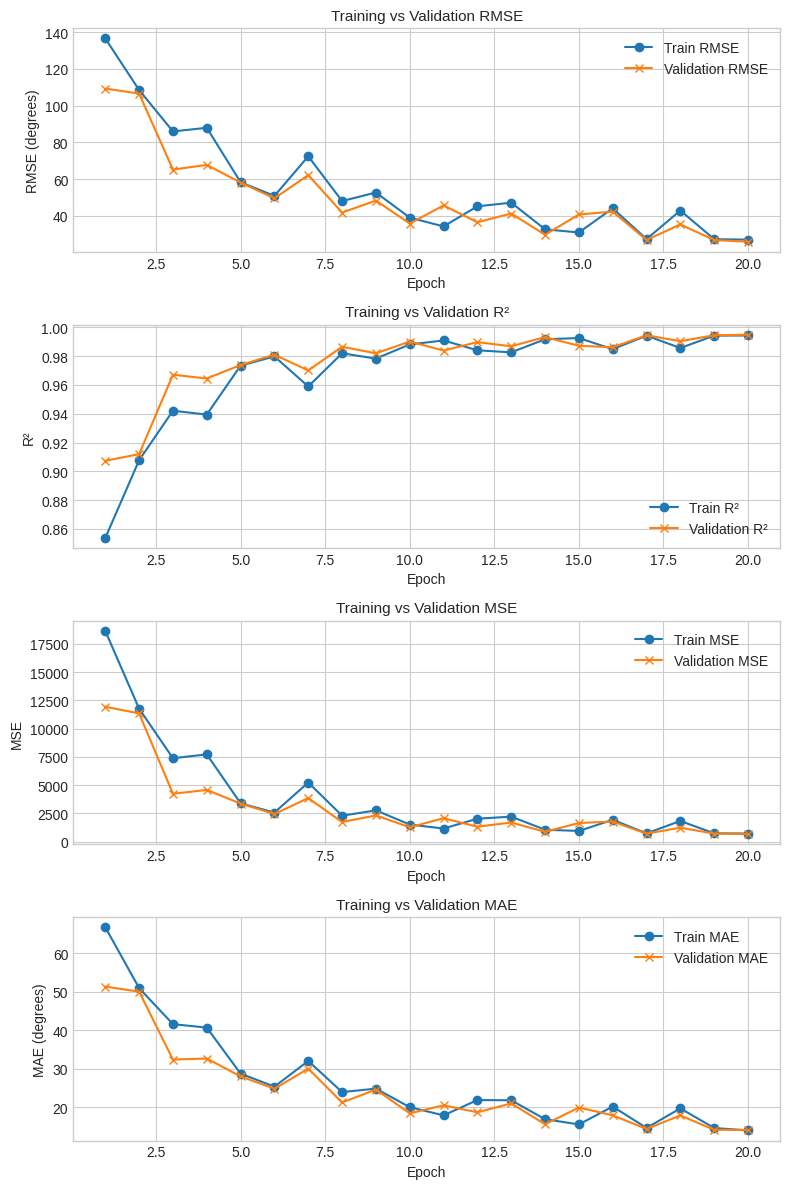

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Metrics CSV ---
metrics_path = log_dir  # Adjust path if needed
metrics_csv = os.path.join(metrics_path, 'metrics.csv')
df = pd.read_csv(metrics_csv)

# --- Plot Configuration ---
plt.style.use("seaborn-v0_8-whitegrid")  # for Matplotlib 3.6+

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

metrics = [
    ("train_rmse", "val_rmse", "RMSE"),
    ("train_r2", "val_r2", "R²"),
    ("train_mse", "val_mse", "MSE"),
    ("train_mae", "val_mae", "MAE")
]

for idx, (train_col, val_col, label) in enumerate(metrics):
    axs[idx].plot(df["epoch"], df[train_col], label=f"Train {label}", marker='o')
    axs[idx].plot(df["epoch"], df[val_col], label=f"Validation {label}", marker='x')
    axs[idx].set_title(f"Training vs Validation {label}", fontsize=11)
    axs[idx].set_xlabel("Epoch")
    if (label == "RMSE" or label == "MAE"):
       axs[idx].set_ylabel(label+" (degrees)")
    else: 
        axs[idx].set_ylabel(label)
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()

# --- Save Plots ---
fig.savefig(os.path.join(log_dir,"training_validation_metrics.png"), dpi=300)

print("✅ Saved: training_validation_metrics.png")

## --- Plot Configuration ---
# plt.style.use("seaborn-v0_8-whitegrid")  # for Matplotlib 3.6+

# fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# metrics = [
#     ("train_rmse", "val_rmse", "RMSE"),
#     ("train_r2", "val_r2", "R²"),
#     ("train_mse", "val_mse", "MSE"),
#     ("train_mae", "val_mae", "MAE")
# ]

# for idx, (train_col, val_col, label) in enumerate(metrics):
#     axs[idx].plot(df["epoch"], df[train_col], label=f"Train {label}", marker='o')
#     axs[idx].plot(df["epoch"], df[val_col], label=f"Validation {label}", marker='x')

#     # --- Use test_metrics dict to draw test line ---
#     test_value = test_metrics[label]
#     axs[idx].axhline(y=test_value, color='red', linestyle='--', label=f"Test {label}")

#     axs[idx].set_title(f"Training vs Validation {label}", fontsize=11)
#     axs[idx].set_xlabel("Epoch")
#     axs[idx].set_ylabel(label)
#     axs[idx].legend()
#     axs[idx].grid(True)

# plt.tight_layout()

# # --- Save Plots ---
# fig.savefig(os.path.join(log_dir,"training_validation_metrics_with_test.png"), dpi=300)
# fig.savefig(os.path.join(log_dir,"training_validation_metrics_with_test.pdf"))

# print("✅ Saved: training_validation_metrics_with_test.png and training_validation_metrics_with_test.pdf")


Test Data / Summary Plot

✅ Saved: final_rmse_by_split.png


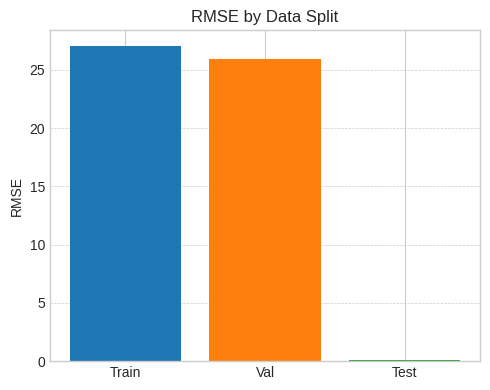

✅ Saved: final_mae_by_split.png


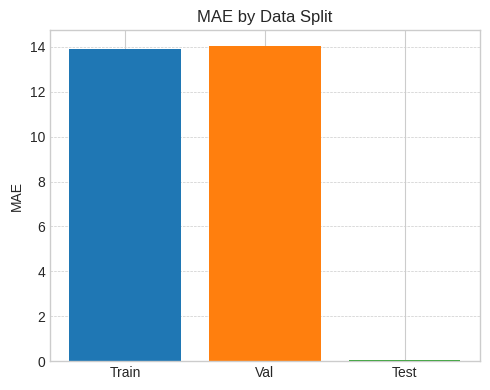

✅ Saved: final_r²_by_split.png


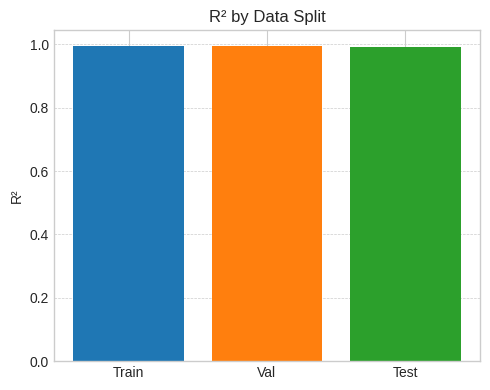

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load last row from CSV ---
# df = pd.read_csv("logs/run_2025-04-13_12-32-27/metrics.csv")
df = pd.read_csv(os.path.join(log_dir,"metrics.csv"))
final_row = df.iloc[-1]

# --- Train & Val Metrics ---
final_metrics = {
    "Train": {
        "RMSE": final_row["train_rmse"],
        "MAE": final_row["train_mae"],
        "R²": final_row["train_r2"]
    },
    "Val": {
        "RMSE": final_row["val_rmse"],
        "MAE": final_row["val_mae"],
        "R²": final_row["val_r2"]
    }
}

# --- Compute Test Metrics from loader ---
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)
        pred = model(X_test_batch)
        all_preds.append(pred.cpu())
        all_targets.append(y_test_batch.cpu())

y_true = torch.cat(all_targets).numpy()
y_pred = torch.cat(all_preds).numpy()

final_metrics["Test"] = {
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "MAE": mean_absolute_error(y_true, y_pred),
    "R²": r2_score(y_true, y_pred)
}

# --- Plot one figure per metric ---
for metric in ["RMSE", "MAE", "R²"]:
    values = [final_metrics[split][metric] for split in ["Train", "Val", "Test"]]
    plt.figure(figsize=(5, 4))
    plt.bar(["Train", "Val", "Test"], values, color=["tab:blue", "tab:orange", "tab:green"])
    plt.ylabel(metric)
    plt.title(f"{metric} by Data Split")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir,"final__by_split.png"), dpi=300)

    print(f"✅ Saved: final_{metric.lower()}_by_split.png")
    plt.show()
